# Indoor Climate Analysis and Prediction

- Deepan Sanghavi
- Applying for Data Scientist Position
- I hope my work helps you to know my caliber in this field

As a first step, I will start with the exploration and come up with a problem statement. This notebook is divided in two parts:
- Exploration with Problem Statement
- Prototype Model Building

Initial Exploration:
-	Firstly, I was trying to understand the data and I started analyzing the excel columns. What I interpreted from that is it is a time series data where you are getting data from sensors after every time specific interval.
- Also, after reading the data description, we have following things:
    - Time Stamp – In Unix format which needs to be converted in normal timestamp format for understanding purpose
    - House – House number
    - Room – Room number
    - Room set point - This is considered to be the goal temperature for healthy lifestyle
    - Room Temperature - Sensors records the room temperature at time t
    - Room Humidity - Sensors records the room humidity at time t
    - Room Pressure - Sensors records the room pressure at time t
    - Vent Pressure – Sensors records the vent pressure for time t. Also, if the pressure is increasing than the fan is on or else it is off
    - Vent Temperature – If it is higher than room temperature than it is in heat mode or else it is in cool mode

In [380]:
# All Import statments
import pandas as pd
from datetime import datetime, timedelta 
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import seaborn as sns
import os
from meteocalc import Temp, dew_point, heat_index
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_model import ARIMA
from scipy.optimize import brute
import warnings
warnings.filterwarnings('ignore')

In [381]:
# Change the path file over here
path_data = "/home/p2017-999/acs_data/processed_data/chest_xray/CXR8/Text_work"

In [382]:
# read data
data = pd.read_csv(os.path.join(path_data,"ecovent-data.csv"))

In [383]:
data.head()

,time,home,room,room_setpoint,room_temp,room_hum,room_pres,vent_temp,vent_pres
0,1519516860,10015,1,25.0,24.1609,43.4118,1022.6052,3.3417,1017.4021
1,1519516920,10015,1,25.0,24.1394,44.5638,1022.6553,6.7375,1017.8040
2,1519516980,10015,1,25.0,24.1287,43.9535,1022.6050,6.8875,1017.3743
3,1519517040,10015,1,25.0,24.1501,44.0450,1022.6914,6.9583,1017.3835
4,1519517100,10015,1,25.0,24.1716,44.1671,1022.6560,7.1271,1017.3613


- Reason for comming up with new feature as temperature feels like has been explained later

In [384]:
# Add temperature like
data["Temperature_Feels_Like"] = data.apply(lambda x: heat_index(Temp(x["room_temp"], 'c'), x["room_hum"]).c, axis=1)

- In Input data, time is in unix format. Hence, it has been converted to normal format for understandability

In [385]:
# Conver unix time to normal timestamp
data["Time_normal"] = data.apply(lambda x: datetime.fromtimestamp(x["time"]).strftime('%Y-%m-%d %H:%M:%S'), axis=1)

##### Next Step: As it is time series data, I thought of let’s put on the time plot and understand the behavior. Below is the time plot.

In [387]:
# Explore the series
def filter_based_on_product(Home, Room):
    sns.set(style="whitegrid", color_codes=True)
    temp = data.loc[(data["home"] == Home) & (data["room"] == Room)]
    
    # Plot room setpoint vs time
    x = temp.loc[:,"room_setpoint"].tolist()
    fig=plt.figure(figsize=(10, 5))
    plt.plot(x)
    plt.ylabel('Room Setpoint')
    plt.show()
    
    # Plot room temperature vs time
    x = temp.loc[:,"Temperature_Feels_Like"].tolist()
    fig=plt.figure(figsize=(10, 5))
    plt.plot(x)
    plt.ylabel('Temperature Feels Like')
    plt.show()
    
    # Plot room humadity vs time
    x = temp.loc[:,"room_hum"].tolist()
    fig=plt.figure(figsize=(10, 5))
    plt.plot(x)
    plt.ylabel('Room Humadity')
    plt.show()
    
    
        # Plot room Pressure vs time
    x = temp.loc[:,"room_pres"].tolist()
    fig=plt.figure(figsize=(10, 5))
    plt.plot(x)
    plt.ylabel('Room Pressure')
    plt.show()
    

        # Plot Error = Temperature_Feels_Like - setpoint vs time
    x = (temp.loc[:,"Temperature_Feels_Like"] - temp.loc[:,"room_setpoint"]).tolist()
    fig=plt.figure(figsize=(10, 5))
    plt.plot(x)
    plt.ylabel('Error')
    plt.show()    
    
#         Plot Vent temperature vs time
    x = temp.loc[:,"vent_temp"].tolist()
    fig=plt.figure(figsize=(10, 5))
    plt.plot(x)
    plt.ylabel('Vent Temperature')
    plt.show()
    
        # Plot Vent Pressure vs time
    x = temp.loc[:,"vent_pres"].tolist()
    fig=plt.figure(figsize=(10, 5))
    plt.plot(x)
    plt.ylabel('Vent Pressure')
    plt.show()
interact(filter_based_on_product, Home = data.home.sort_values().unique().tolist(), Room = data.room.sort_values().unique().tolist())

A Jupyter Widget

<function __main__.filter_based_on_product>

### Things that I extracted from time plots:

-	Room pressure is correlated with Vent Pressure. Hence, we can consider one of them. We will consider room pressure as it is more important because of fan information

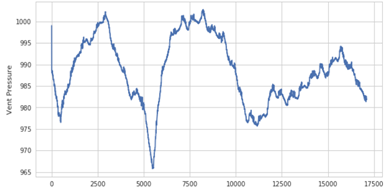

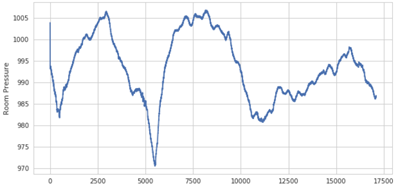

-	Vent temperature fluctuates a lot between the ranges of 10-50. Hence, predicting the future vent temperature does not make sense. Reason because of its fluctuation nature, we cannot makes just this as a problem statement. Getting the answer whether the system should be in heat mode or cold mode is not very useful. May be we can use the prediction to combine with some other problem which we will discuss later.
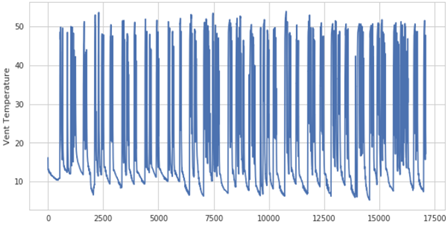

-	Vent pressure is seasonal in nature. So I am assuming that Ecovent is finding out the way using some algorithm to adjust the vent pressure i.e. answering the question whether to switch on the fan or not.
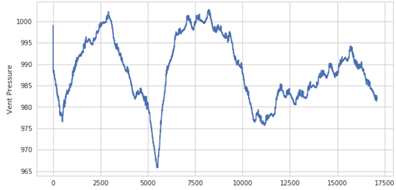

But there is a possibility it correlates with the set point. Eg: If the set point increases, fan will start. But, that is not the case which can be found out from below case:
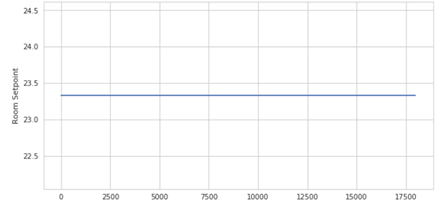

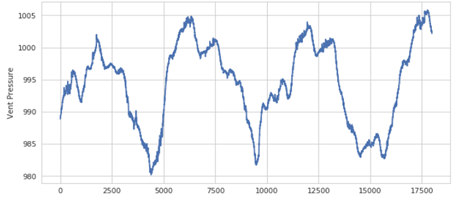

Hence, Ecovent is using some algorithm to find out whether to increase the pressure or decrease the pressure based on sensor readings

##### Humidity
- Next I was reading about humidity. Humidity is the level of water content in the air.
- From exploration humidity seems to be in the range of 30-50. 
- Important thing that I read was usually, humidity in conjunction with the temperature decides the comfort level of the person.
- As the humidity increases beyond 30%, temperature feels like also increases
- Hence, I decided to add a metric called temperature feels like instead of room temperature as it is the more accurate metric
- You can see the below chart for temperature feels like index (Red – Uncomfortable, Yellow - Comfortable)

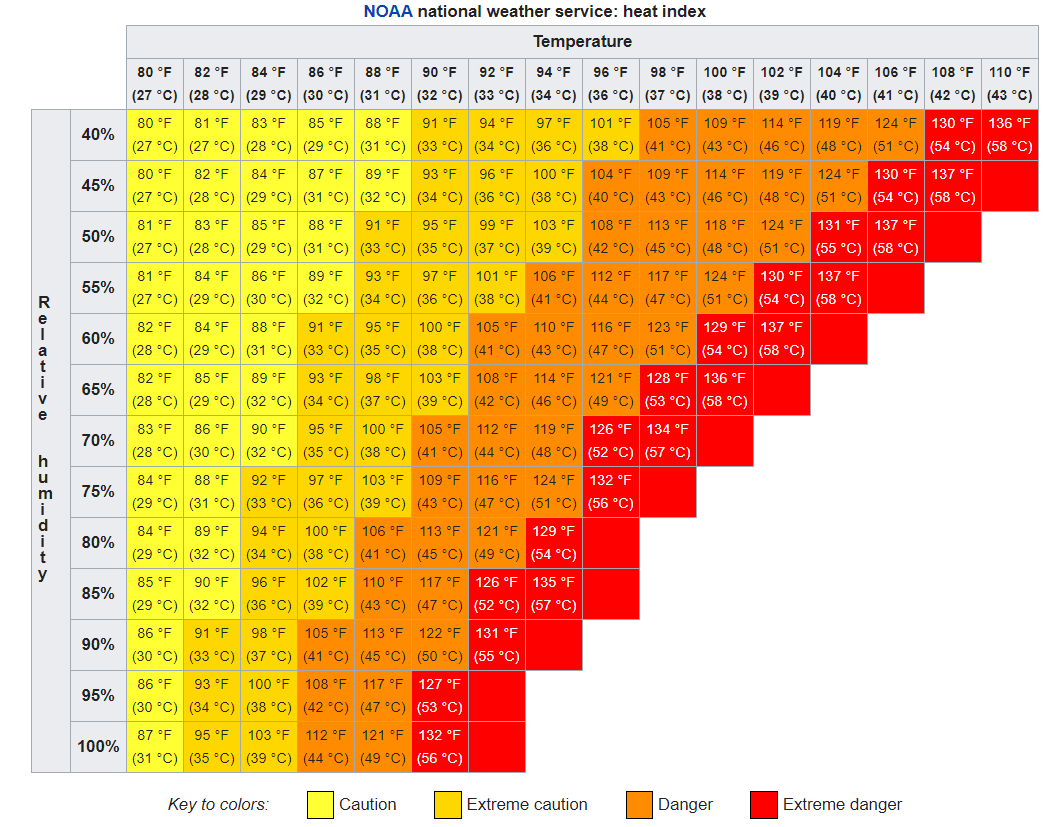

Soruce: https://en.wikipedia.org/wiki/Heat_index

- This can be one of the problem statements to solve where ecovent is trying to set the temperature such that the comfort level is usually in yellow region. But this problem seems to be more useful where user selects the auto mode as you have the control to select the temperature such that user stays healthy
- But if the user selects its own temperature, than your goal shift away from the above standards. You want to go close to room set point

This motivated me to further explore the set point and I found out that data has following types of user:

- User which have defined threshold point:
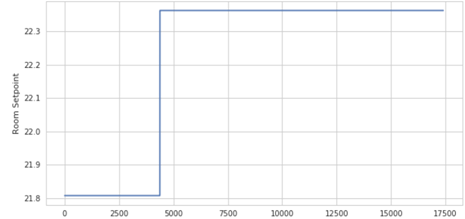

- User who have used the auto set point mode: This is where we can use humidity problem statement to set the temperature according to the index and try to adjust the pressure and temperature to meet closely to this requirements. Advantages would be that you won’t have such fluctuating room set point. Instead you can set the setpoint to defined standards which further reduces the power consumption.
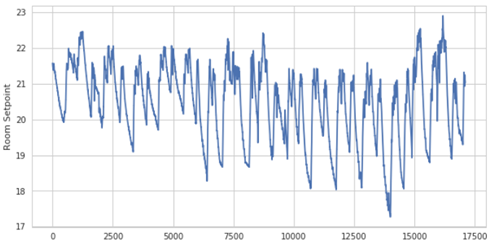

- Users who wants to change temperature after specific time
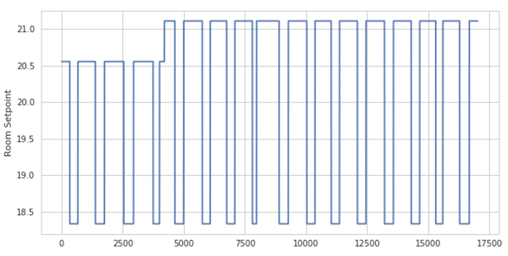

##### After all this, I was thinking in direction of how I can improve the existing ecovent algorithm. Hence, I inserted an additional index called the Error = Temperature Feels Like - Room Set point. This will give us how far we are from our goal and I have also visualized that.

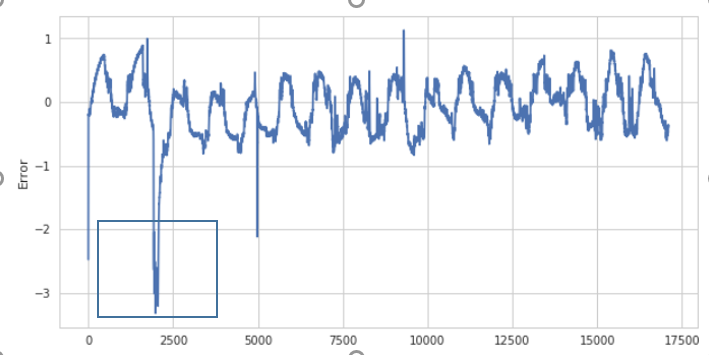

### Now I am set to define the problem statement.

##### Problem Statement: Predict in future when the user won’t be in a comfortable environment and based on that decide whether to cool or heat

I know there are several factors like number of people and dimensions of the room, but this system will work based on house and room number. E.g. Input data would be for house number 200 and room 1.
Plan:
-	Create a model to predict temperature feels like = Model1 (I want to create multi variate model)
-	Create time series model to predict Room Setpoint, Vent pressure, Vent temperature, Humidity (No room pressure as it is correlated to Vent pressure) See Below:

In [434]:
# finding correlation
data.corr(method = "pearson")

,time,home,room,room_setpoint,room_temp,room_hum,room_pres,vent_temp,vent_pres,Temperature_Feels_Like
time,1.000000,-0.003823,0.000852,-0.041631,-0.051028,-0.248774,-0.099240,0.072502,-0.085632,-0.070227
home,-0.003823,1.000000,-0.014366,0.234383,0.171952,0.264513,0.256921,0.000061,0.310528,0.193849
room,0.000852,-0.014366,1.000000,0.121174,0.042091,-0.048962,-0.045660,0.039354,-0.044729,0.038562
room_setpoint,-0.041631,0.234383,0.121174,1.000000,0.520496,-0.059716,0.039546,0.080471,0.044316,0.517847
room_temp,-0.051028,0.171952,0.042091,0.520496,1.000000,-0.110746,0.021182,0.105751,0.039482,0.995880
room_hum,-0.248774,0.264513,-0.048962,-0.059716,-0.110746,1.000000,0.241107,-0.206552,0.262840,-0.033261
room_pres,-0.099240,0.256921,-0.045660,0.039546,0.021182,0.241107,1.000000,-0.082084,0.916672,0.039743
vent_temp,0.072502,0.000061,0.039354,0.080471,0.105751,-0.206552,-0.082084,1.000000,-0.027486,0.090042
vent_pres,-0.085632,0.310528,-0.044729,0.044316,0.039482,0.262840,0.916672,-0.027486,1.000000,0.059772
Temperature_Feels_Like,-0.070227,0.193849,0.038562,0.517847,0.995880,-0.033261,0.039743,0.090042,0.059772,1.000000


-	Using above outputs of time series model, get the future temperature feels like using Model1
-	Based on the humidity temperature index, find out the person is comfortable or not

###### AND

-	Calculate Error =  Temperature feels like – Set point and say whether it should heat or cool for all future instances

##### This is better than directly creating model for temperature because you are creating multivariate model rather than univariate.


In [389]:
data.head()

,time,home,room,room_setpoint,room_temp,room_hum,room_pres,vent_temp,vent_pres,Temperature_Feels_Like,Time_normal
0,1519516860,10015,1,25.0,24.1609,43.4118,1022.6052,3.3417,1017.4021,23.766076,2018-02-24 19:01:00
1,1519516920,10015,1,25.0,24.1394,44.5638,1022.6553,6.7375,1017.8040,23.772506,2018-02-24 19:02:00
2,1519516980,10015,1,25.0,24.1287,43.9535,1022.6050,6.8875,1017.3743,23.744800,2018-02-24 19:03:00
3,1519517040,10015,1,25.0,24.1501,44.0450,1022.6914,6.9583,1017.3835,23.770729,2018-02-24 19:04:00
4,1519517100,10015,1,25.0,24.1716,44.1671,1022.6560,7.1271,1017.3613,23.797568,2018-02-24 19:05:00


##### We can see above that sensor is returning the value every minute

In [391]:
# Count the number of instances we have for each room and house

pd.options.display.max_rows = 10 # 1000 # Print all rows pandas

data[["home","room","time"]].groupby(["home","room"]).count()

time
home  room       
37    1     17103
      2     17100
      3     17103
      4     17087
      5     17027
...           ...
10133 7     17465
      8     17455
      9     17494
      10    17440
      11    17443

[234 rows x 1 columns]

In [392]:
pd.options.display.max_rows = 10 #1000 # Print all rows pandas
data.groupby(["home","room"]).head(3)

,time,home,room,room_setpoint,room_temp,room_hum,room_pres,vent_temp,vent_pres,Temperature_Feels_Like,Time_normal
0,1519516860,10015,1,25.0000,24.1609,43.4118,1022.6052,3.34170,1017.40210,23.766076,2018-02-24 19:01:00
1,1519516920,10015,1,25.0000,24.1394,44.5638,1022.6553,6.73750,1017.80400,23.772506,2018-02-24 19:02:00
2,1519516980,10015,1,25.0000,24.1287,43.9535,1022.6050,6.88750,1017.37430,23.744800,2018-02-24 19:03:00
18081,1519516860,10015,10,25.0000,24.5041,45.2123,1022.6958,4.41250,1017.73800,24.190609,2018-02-24 19:01:00
18082,1519516920,10015,10,25.0000,24.5470,46.6161,1022.7229,8.45000,1017.76290,24.274454,2018-02-24 19:02:00
...,...,...,...,...,...,...,...,...,...,...,...
4061393,1519516860,71,6,21.6667,23.0776,41.0848,1026.6780,19.11670,1018.52540,22.513685,2018-02-24 19:01:00
4061394,1519516920,71,6,21.6667,23.0776,41.0848,1026.6780,19.11670,1018.52540,22.513685,2018-02-24 19:02:00
4078820,1519516800,71,8,22.2222,23.6675,44.4875,1022.7524,21.93020,1019.20665,23.251424,2018-02-24 19:00:00
4078821,1519516860,71,8,22.2222,23.6675,44.4875,1022.7524,21.93020,1019.20665,23.251424,2018-02-24 19:01:00


##### So we have around 17000 entries for each category(home and room) but don't have same number of entries
##### Also, all the category have same start time stamp

### Prototype of Predicition System

#### Set for which home and room you need the prediction

In [453]:
# as each specific room and house would have different dimensions and parameters. So we should make different model for each.
home_number = 37
room_number = 1

# Number of future time steps to froecast. eg: I want to know 30 minutes ahead forecast
n = 30

In [454]:
def preprocess(data, home, room_number):
    
    # filter based on input home and room number
    main_data =  data[(data["home"]==home_number) & (data["room"] == room_number)] # Filter according to the home and room
    main_data.index = np.arange(0, len(main_data)) # Reseting the index
    
# drop room temperature and pressure
# Reasons: 
# - Temperature Feels Like is a better parameter by using domain knowledge
# - Room Pressure is correlated with Vent pressure. Hence, keep only one.
    main_data = main_data.drop(["room_temp", "room_pres"], axis = 1)
    return main_data

### Create Model1 to predict temperature Feels Like

In [455]:
###### splitting data into train and test. Train 80% test 20%
def split_data(main_data):
    
    X = main_data.iloc[:,3:-2] # Independent columns 
    X_train, X_test, Y_train, Y_test = train_test_split(X, main_data.loc[:,"Temperature_Feels_Like"], test_size=0.2, random_state=42)
    return X_train, X_test, Y_train, Y_test

Create Random Forest model as it is my favourite one.
As it is a regression problem, I am using Random forest regressor
Reason for Random Forest:
- Use Bagging Concept to sample the data and take averages which reduces bias
- Extract Random features from set to decorrelate several trees. Hence reduces Bias
- It is a non linear algorithm and all real world data set are mostly non linear in shape as we saw in graphs

- Input Features = Room Set Point + Room Humidity + Vent Temperature + Vent Pressure
- Output = Temperature Feels Like

- Tune the parameter and take the best one using grid search
    - n_estimators = Number of trees to be formed to take an average
    - max_features =  number of features to consider. sqrt means square root of number of features
    - max depth = how much deep trees you need. smaller is better usually as it doesnt over fits

In [456]:
def model1():
    
    # preprocess
    main_data = preprocess(data, home_number, room_number)
    
    # Split
    X_train, X_test, Y_train, Y_test = split_data(main_data)
    
    # Model
    regression = RandomForestRegressor(random_state=0)
    
    # Grid search
    param_grid = { "n_estimators"      : [250,500,750],
               "max_features"      : ["sqrt","log2"],
               "max_depth"         : [5, 10, 15]}
    grid_search_model1 = GridSearchCV(regression, param_grid, n_jobs=-1, cv=10)
    grid_search_model1.fit(X_train, Y_train)
    print("Best Parameters: ", grid_search_model1.best_params_)
    print("Train Rsquare: ", grid_search_model1.best_score_)
    # get the predictions of test set
    predictions = grid_search_model1.predict(X_test)
    # get r square on test set
    print("Test Rsquared : ",r2_score(Y_test, predictions))
    return main_data

In [457]:
# Run the model 1
main_data = model1()

Best Parameters:  {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 750}
Train Rsquare:  0.9914934165710896
Test Rsquared :  0.9912691479896992


#### Used R-squared as the parameter to compare as it is accurate way to say whether what ratio of variance is covered by the model. Also, adjusted r-squared is better than R-square as Adjusted R square puts penalty term on number of features used. But, we are not trying to add or remove the features. Hence, anything is fine in our case

### Create Time series model to predict future 30 minutes of Vent Pressure, Vent Temperature, and Room Humidity

In [458]:
# test = most recent n minutes data
def data_split(data, n):
    
    train = data[0:(len(main_data)-(n))]
    test = data.tail(n)
    return train, test

In [459]:
# Applying Time series model like ARIMA

##### Why ARIMA?

- Reason for using arima is that for univariate data, as in our case, ARIMA is the most famous time series algorthms which uses the assumption of stationarity (mean and variance of series is independent of time). I have used this earlier and hence, I am using it as my first algorithm.

- I am using MAPE as a metric as it gives you value between 0-100 using which you can compare several models. Also, it is useful when you have target value is not normalized accross data set. Example: if one temperature is in Celsius and other is in Kelvin, then MAPE independent of units, allow us to compare both the models

- I am using n- steps forecast

#### Challenges with ARIMA

- You have to give AR term(p), differencing term (d), and MA term(q). FIrst what are these terms (won't explain in detail).
    - d is usually a differencing term which is use to make a series stationary
    - p and q terms depends on the autocorrelation and partial autocorrelation plot. If ACF has decreasing trend then you use AR model and PACF has decreasing trend then MA model is used and if both of them has, then you use combination of both
    
- Challenges: In our case, there will be several time series model depending on house and room number. So deciding p, d, and q for all the series is not feasible. One solution that I used in past was clustering the series and identify the clusters and decide p,d,q values for each cluster. But as this is prototype model, I will various combinations of p,d,q and select with lowest test error.

In [460]:
# Calculate mean absolute percentage error
def mape(true_labels, pred_labels):
    return np.mean(np.abs((true_labels - pred_labels) / true_labels)) * 100

- Using ARIMA model. But there are several others like ETS, Holts Winter, STL decomposition and Linear regression methods where features are lagged values. Also, we can use Ensemble methods which takes combination of this. I frequired, I can send you one of my similar work

In [461]:
# ARIMA model
# Parameters: order is p,d,q values: train data: test data: flag varaible
def model_implement(order, train, test, flag):
    # Try block reason: some order are not compatible with few of the series. then in such a case, I am return max mape error
    try:
        model = ARIMA(train.values, order = order)
        model_fit = model.fit(disp = 0)
        prediction = model_fit.forecast(steps = n)[0]
        mape_error = mape(test.values, prediction)
    except:
        mape_error = 100
        return mape_error
    
    if flag==0: # find out the best model
        return mape_error
    else: # return predictions of the best model
        return prediction

In [462]:
# order to try
order = [ (0, 0, 0), (1, 0, 0), (0, 0, 1), (1, 1, 0), (0, 1, 1), (1, 1, 1), (1, 2, 1), (2, 2, 0), (0, 2, 2)]

In [463]:
# This Takes time to run
final_predictions = pd.DataFrame(columns=["Time","room_setpoint" , "room_hum", "vent_temp", "vent_pres","Temperature_Feels_Like"]) # Pandas Dataframe to store predictions of all features

for y in ["room_setpoint" , "room_hum", "vent_temp", "vent_pres"]:
    train, test = data_split(main_data.loc[:,y], n) # train and test split
    mape_error = []
    for x in range(len(order)):
        # create train and test data
        mape_error.append(model_implement(order[x], train, test, 0))
    final_predictions[y] = model_implement(order[np.argmin(mape_error)], train, test, 1) # take results of best MAPE error
    print("MAPE for ",y," is : ", np.min(mape_error))

MAPE for  room_setpoint  is :  0.4159765618013733
MAPE for  room_hum  is :  0.723441857692603
MAPE for  vent_temp  is :  27.947387281644172
MAPE for  vent_pres  is :  0.0630008273157804


### Error Comments
- Room Set point will be less in cases where the input is constant
- Room humidity and vent pressure are very good as it is less than 1 % MAPE
- Vent temperature is a bit high but looking at its variablity, it is good
-  This holds true in most of the combination of home and room values

#### All the parameters can be further improved. Eg: Vent temperature can be improved if we can capture the seasonality

In [464]:
# Get the final Temperature Predictions using Model 1 for future N timesteps
final_predictions["Temperature_Feels_Like"] = grid_search_model1.predict(final_predictions.iloc[:,1:-1])

In [465]:
# Find out the error from set point
final_predictions["Error"] = final_predictions["Temperature_Feels_Like"] - final_predictions["room_setpoint"]

In [466]:
# get the future time stamps from current

time = datetime.strptime(main_data["Time_normal"].tail(1).values[0], '%Y-%m-%d %H:%M:%S')
for x in range(len(final_predictions)):
    
    time = time + timedelta(minutes = 1)
    final_predictions.loc[x, "Time"] = time.strftime('%Y-%m-%d %H:%M:%S')

In [467]:
# you can define the threshold for how much error is accepted. You can also find this parameter from the data
threshold = 1

In [468]:
# Final Decision ---- Heat or cool the system

for x in range(len(final_predictions)):
    if abs(final_predictions.loc[x, "Error"]) > threshold:

        if np.sign(final_predictions.loc[x,"Error"]) == 1:
            final_predictions.loc[x,"Decision"] = "Cool the system"
        else:
            final_predictions.loc[x,"Decision"] = "Heat the system"

### Additional Application: 

- As mentioned earlier, you can use the define standards for how comfortable the person is.
- This is more useful when user wants an auto mode
- definition of comfortable can be changed based on locations
- https://en.wikipedia.org/wiki/Heat_index used this as reference

In [469]:
for x in range(len(final_predictions)):
    
    if final_predictions.loc[x, "Temperature_Feels_Like"] <33:
        final_predictions.loc[x, "User_Comfortability"] = "Comfortable"
    else:
        final_predictions.loc[x, "User_Comfortability"] = "Uncomfortable"

In [470]:
# Final Predictions
pd.options.display.max_rows = 100 # Print all rows pandas
final_predictions

,Time,room_setpoint,room_hum,vent_temp,vent_pres,Temperature_Feels_Like,Error,Decision,User_Comfortability
0,2018-03-12 17:46:00,20.984989,25.033176,18.813020,981.379285,19.670600,-1.314389,Heat the system,Comfortable
1,2018-03-12 17:47:00,20.984878,25.029809,20.823969,981.380369,19.862111,-1.122767,Heat the system,Comfortable
2,2018-03-12 17:48:00,20.984767,25.027285,20.823969,981.381454,19.862111,-1.122656,Heat the system,Comfortable
3,2018-03-12 17:49:00,20.984656,25.024955,20.823969,981.382538,19.860347,-1.124308,Heat the system,Comfortable
4,2018-03-12 17:50:00,20.984544,25.022670,20.823969,981.383622,19.860385,-1.124159,Heat the system,Comfortable
5,2018-03-12 17:51:00,20.984434,25.020394,20.823969,981.384707,19.860385,-1.124048,Heat the system,Comfortable
6,2018-03-12 17:52:00,20.984323,25.018120,20.823969,981.385790,19.860385,-1.123937,Heat the system,Comfortable
7,2018-03-12 17:53:00,20.984212,25.015847,20.823969,981.386874,19.860385,-1.123827,Heat the system,Comfortable
8,2018-03-12 17:54:00,20.984101,25.013574,20.823969,981.387958,19.860385,-1.123716,Heat the system,Comfortable
9,2018-03-12 17:55:00,20.983990,25.011300,20.823969,981.389041,19.860385,-1.123605,Heat the system,Comfortable


### As you can see above, it gives you idea of when you are suppose to heat or cool the system.

- Accuracy of the features that I have predicited is being tested on test set. An additional step could have been perfromed where we are testing this commands on test set and see how it does on error.
- this is just a prototype and final would be much better than the above one
- Also we can create a dashboard where you get the future commands and on the basis of that you can take action
- Both the models